In [1]:
import numpy as np
import netCDF4 as nc
import csv 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as pltd
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from matplotlib.collections import PolyCollection
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import pandas
import xarray as xr
import xesmf
import copy
import time
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

Could not save font_manager cache [Errno 28] No space left on device


In [2]:
def plot_point(ax,data,cmap,bounds,colorbar=False,title=None):
    
    norm = mcolors.BoundaryNorm(bounds, cmap.N)#, extend='both')
    P = ax.scatter(lon,lat,c=data, s=300,cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
    if index == 0:
        ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
        ax.coastlines(zorder=55)
    

In [3]:
import os, psutil, numpy as np # psutil may need to be installed
def usage():
    process = psutil.Process(os.getpid())
    return process.memory_info()[0] / float(2 ** 20)

In [4]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

var_dom = np.ma.where(nep_topo>10,3,1)
var_dom = np.ma.masked_array(var_dom, var_dom == 1)
coors=np.hstack((nep_lon.reshape(-1, 1), nep_lat.reshape(-1,1)))

In [5]:
# Load CalCOFI data
calcofi_data = '/work/role.medgrp/NEP/plotting/Figure_25/194903-202010_Bottle.csv'
station_fil = '/work/role.medgrp/NEP/plotting/Figure_25/CalCOFIStationOrder.csv'
df_locations = pandas.read_csv(station_fil,encoding= 'unicode_escape')
df_locations

,Order Occ,Line,Sta,Lat (dec),Lat (deg),Lat (min),Lat (deg min),Lon (dec),Lon (deg),Lon (min),Lon (deg min),Est Depth,Sta Type
0,1,93.3,26.7,32.95637,32,57.4,32 57.38,-117.30538,117,18.3,117 18.32,63,ROS
1,2,93.4,26.4,32.94905,32,56.9,32 56.94,-117.27357,117,16.4,117 16.41,20,SCCOOS
2,3,91.7,26.4,33.24350,33,14.6,33 14.61,-117.46542,117,27.9,117 27.93,20,SCCOOS
3,4,93.3,28.0,32.91304,32,54.8,32 54.78,-117.39438,117,23.7,117 23.66,609,ROS
4,5,93.3,30.0,32.84637,32,50.8,32 50.78,-117.53122,117,31.9,117 31.87,846,ROS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,109,60.0,60.0,37.61410,37,36.8,37 36.85,-123.60825,123,36.5,123 36.49,3298,ROS
109,110,60.0,70.0,37.28077,37,16.8,37 16.85,-124.33237,124,19.9,124 19.94,3999,ROS
110,111,60.0,80.0,36.94743,36,56.8,36 56.85,-125.05327,125,3.2,125 3.20,4339,ROS
111,112,60.0,90.0,36.61410,36,36.8,36 36.85,-125.77099,125,46.3,125 46.26,4516,ROS


In [6]:
# trend colormap
trend_map = mpl.cm.bwr
bounds = np.linspace(-2,2,17)
norm = mcolors.BoundaryNorm(bounds, trend_map.N, extend='both')

NameError: name 'lon_ca' is not defined

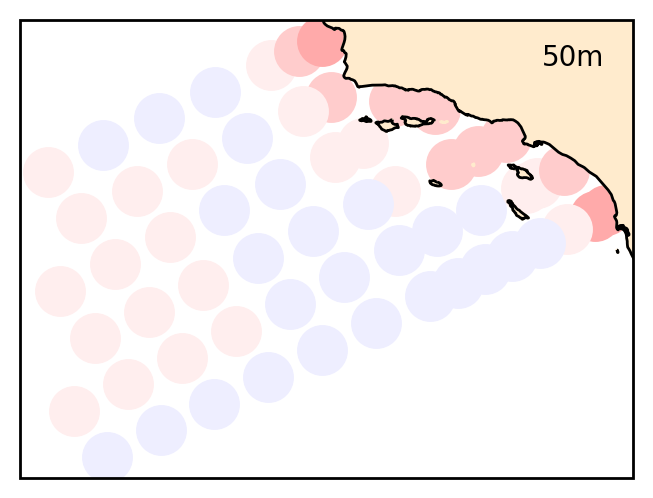

In [8]:
calcofi_nep = '/work/role.medgrp/NEP/plotting/Figure_25/nep_calcofi_values'
df_nep = pandas.read_csv(calcofi_nep,encoding= 'unicode_escape')

# iterate over stations and depths. Calculate trends and significance
depths = [50, 100, 200, 300, 400, 500]
df_sub = copy.deepcopy(df_locations[df_locations['Line']>76])

data_prods = ['NEP', 'CalCOFI']
cal_trend_store = np.zeros((6,len(df_sub)))*np.nan
cal_p_store = np.zeros((len(depths),len(df_sub)))*np.nan

nep_trend_store = np.zeros((6,len(df_sub)))*np.nan
nep_p_store = np.zeros((len(depths),len(df_sub)))*np.nan

fig = plt.figure(figsize=(8,18),dpi=200)
spec = fig.add_gridspec(ncols=2, nrows=6,wspace=.01,hspace=.01)
for data_prod, nprod in zip(['NEP', 'CalCOFI'],range(len(data_prods))):
    
    for ndep,depth_lev in zip(range(len(depths)),depths):
        
        ax = fig.add_subplot(spec[ndep,nprod],projection=ccrs.PlateCarree())
    
        for index, row in df_sub.iterrows():
            lon = row['Lon (dec)'] + 360 # convert longitude to NEP convention
            lat = row['Lat (dec)']
    
            df_line = df_nep[df_nep['Line']==row['Line'] ]
            df_station = df_line[df_line['Station']==row['Sta']]
            df_depth = df_station[df_station['Depthm']==depth_lev]

            if len(df_depth)>1:
                plt_time = np.zeros(len(df_depth))
                for ntime,nt in zip(df_depth['Date'],range(len(df_depth))):
                    plt_time[nt] = pltd.date2num(dt.datetime.strptime(ntime,'%Y-%m-%d'))# %H:%M')
                
                if data_prod == 'NEP':
                    nep_o2 = df_depth['nep_o2']*1000*1000 
                    not_nan_idx = ~np.isnan(nep_o2)
                    if np.sum(not_nan_idx)>0:
                        slope, intercept, r, p, se = stats.linregress(plt_time[not_nan_idx],nep_o2[not_nan_idx])
            
                        nep_trend_store[ndep,index] = slope
                        nep_p_store[ndep,index] = p
            
                        plot_point(ax,365*slope,trend_map,bounds)
                
                else: 
                    cal_o2 = df_depth['Oxy_Âµmol/Kg']  
                    not_nan_idx = ~np.isnan(cal_o2)
                    if np.sum(not_nan_idx)>0:
                        slope, intercept, r, p, se = stats.linregress(plt_time[not_nan_idx],cal_o2[not_nan_idx])
            
                        cal_trend_store[ndep,index] = slope
                        cal_p_store[ndep,index] = p
                    
                        plot_point(ax,365*slope,trend_map,bounds)
            
        plt.setp(ax.spines.values(), linewidth=1,zorder=100)
        ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
        ax.coastlines(zorder=55)
        ax.text(.85,.9,(str(depth_lev) + 'm'),transform=ax.transAxes,zorder=56)
    
        if ndep == 0:
            plt_lon = lon_ca-360
            plt_lat = lat_ca
            ax.set_title(data_prod,fontsize=16)
    
        ax.plot(plt_lon,plt_lat,'o',ms=3,mfc = 'darkgrey',mec='darkgrey',transform=ccrs.PlateCarree())
        
        if data_prod == 'NEP':
            sig_idx = nep_p_store[ndep,:]<0.05
            print(np.sum(sig_idx))
        else:
            sig_idx = cal_p_store[ndep,:]<0.05
            print(np.sum(sig_idx))
            
        ax.plot(plt_lon[sig_idx],plt_lat[sig_idx],'ko',ms=2.5,transform=ccrs.PlateCarree())
    
        if (data_prod) == 'NEP' and (ndep==5):
        
            pos = ax.get_position()
            cax = fig.add_axes([pos.x0, pos.y0-.02, 2*pos.width+.01, .1*pos.height])
            cbar = mpl.colorbar.ColorbarBase(cax, orientation='horizontal',extend='both',cmap=trend_map,
                           norm=norm)
        
            cax.set_xlabel(r'$\Delta$O$_2$ ($\mu$mol kg$^{-1}$ yr$^{-1}$)',fontsize=14)
plt.savefig('Figure25_NEP_CalCOFI_O2_trend_comparisons')    